## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle

%matplotlib qt

#Visualise detected checkerboard corners
visualise = False

# prepare object points
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        if visualise:
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            cv2.imshow('img',img)
            cv2.waitKey(500)

cv2.destroyAllWindows()

In [2]:
def plot_image(img, title=''):
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    plt.axis('off')
    plt.title(title, fontsize=20)

def compare_images(img_org, img_undist):
    # Visualize distortion corrected image as compared to original
    plt.subplots(1, 2, figsize=(20,10))
    plt.subplot(1, 2, 1)
    plot_image(img_org,'Image Before')
    plt.subplot(1, 2, 2)
    plot_image(img_undist,'Image After')

In [3]:
def import_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

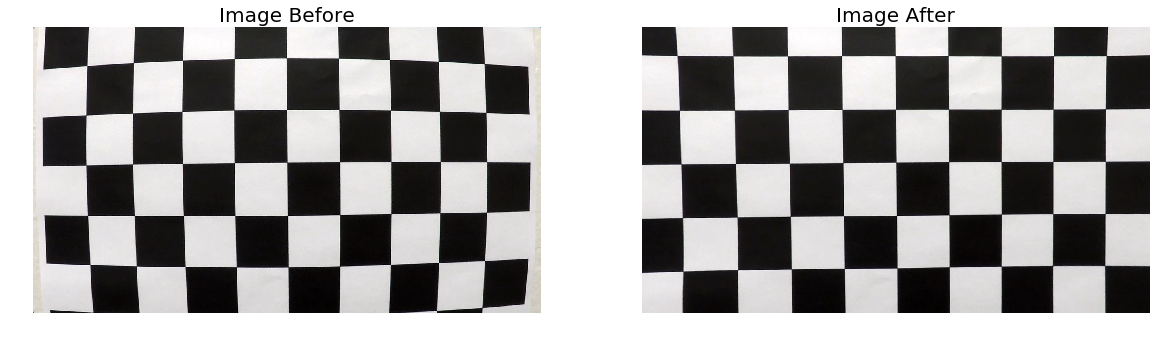

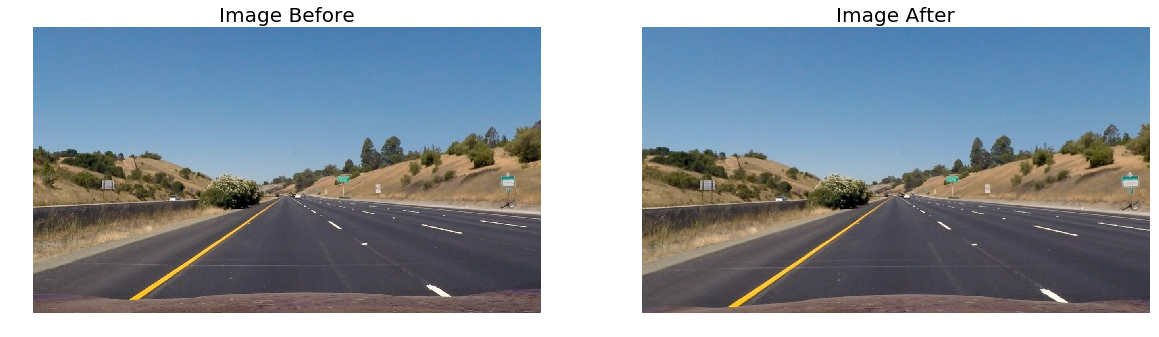

In [4]:
%matplotlib inline

# Camera calibration 
img = import_image('./camera_cal/calibration1.jpg')
img_res = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_res,None,None)
distortion_obj = {"mtx": mtx, "dist": dist}

# Test images:
udist = cv2.undistort(img, mtx, dist, None, mtx)
compare_images(img, udist)

img = import_image('./test_images/straight_lines1.jpg')
udist = cv2.undistort(img, mtx, dist, None, mtx)
compare_images(img, udist)

## Perspective Transform

In [5]:
def perspective_transform(img):
    # Tune source points to ensure that lane lines run 
    # vertically for a straight piece of road.
    
    src_top_left  = [0.45 * img_res[0], 0.624 * img_res[1]]
    src_top_right = [0.55 * img_res[0], 0.624 * img_res[1]]
    src_bot_left  = [0.00 * img_res[0], 0.95 * img_res[1]]
    src_bot_right = [1.00 * img_res[0], 0.95 * img_res[1]]

    dst_top_left  = [0 * img_res[0], 0 * img_res[1]]
    dst_top_right = [1 * img_res[0], 0 * img_res[1]]
    dst_bot_left  = [0 * img_res[0], 1 * img_res[1]]
    dst_bot_right = [1 * img_res[0], 1 * img_res[1]]
    
    src = np.float32([src_top_left
                     ,src_top_right
                     ,src_bot_left
                     ,src_bot_right])

    dst = np.float32([dst_top_left
                     ,dst_top_right
                     ,dst_bot_left
                     ,dst_bot_right])

    perspective_matrix = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(udist, perspective_matrix, img_res)

True

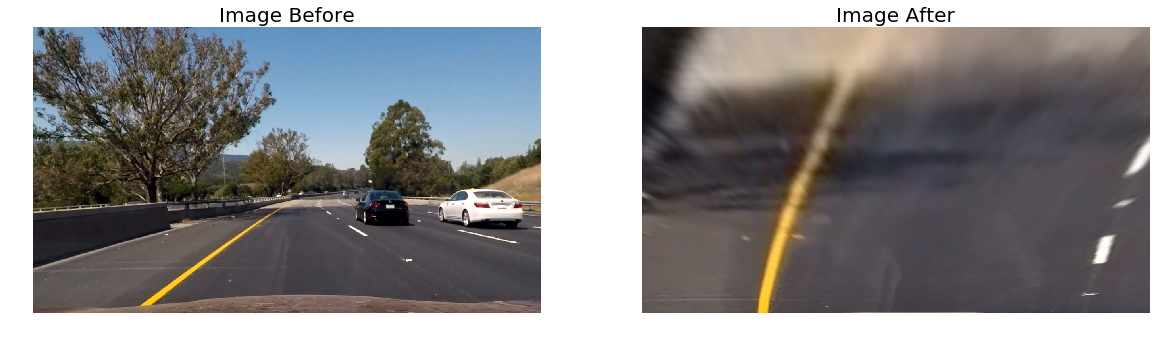

In [212]:
img = import_image('./test_images/test6.jpg')
udist = cv2.undistort(img, mtx, dist, None, mtx)
warped = perspective_transform(udist)
compare_images(udist, warped)
cv2.imwrite('./output_images/test_perspective.jpg',warped)

## Thresholded binary image

In [213]:
def plotColourChannels(image, colorspace="RGB"):
    
    print('Note: Input image must be in RGB color space!')
    
    if not colorspace == 'RGB':
        converter = getattr(cv2, "COLOR_RGB2" + colorspace)
        converted_img = cv2.cvtColor(image, converter)
    else:
        converted_img = image
        
    color_channel_names = {'RGB': ['Red', 'Green', 'Blue']
                          ,'BGR': ['Blue', 'Green', 'Red']
                          ,'HLS': ['Hue', 'Lightness', 'Saturation']
                          ,'HSV': ['Hue', 'Saturation', 'Value']}
    
    assert colorspace in color_channel_names, 'The chosen colorspace does not appear in our list [RGB, BGR, HLS, HSV].'
    
    plt.subplots(2, 2, figsize=(20,12))
    
    for i in range(1,5):
        plt.subplot(2, 2, i)
        if i==1:
            plot_image(image, title='Original Image')
        else:
            title = color_channel_names[colorspace][i-2] + ' Channel'
            plot_image(converted_img[:,:,i-2], title=title)

Plot the image and its color channels to identify features by which the lane lines can be identified.

Note: Input image must be in RGB color space!


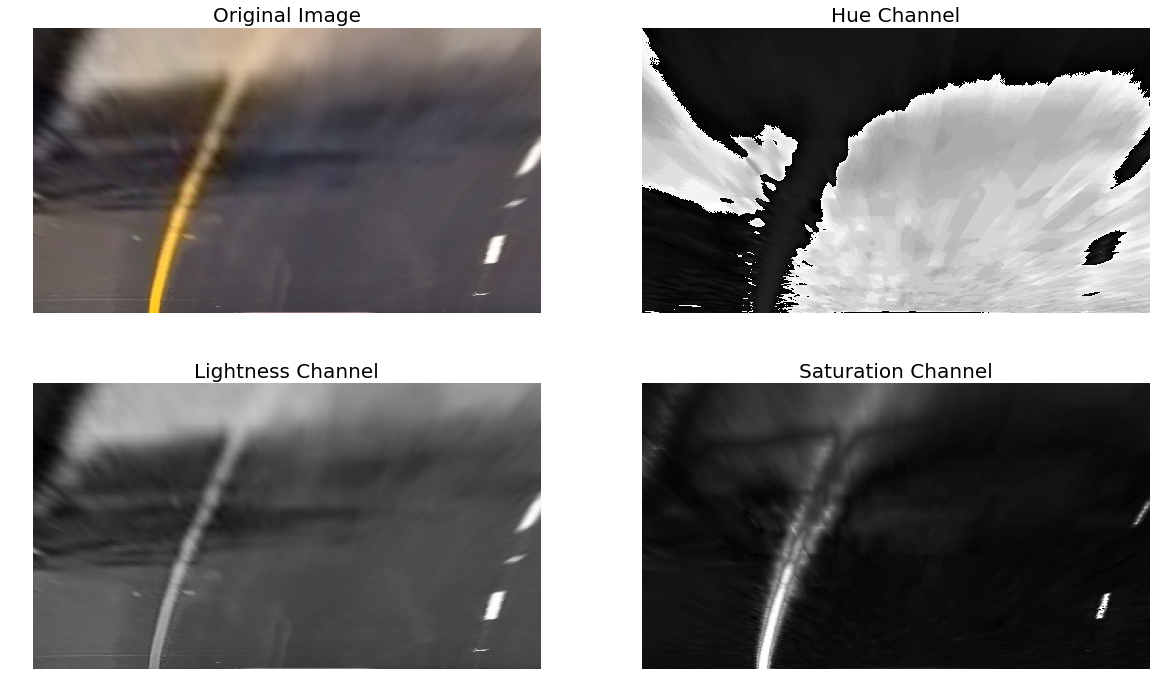

In [214]:
plotColourChannels(warped, colorspace='HLS')

Create a function to shift the input image to the left or the right.

In [215]:
def translate_horz(img, direction='left', shift=0.01):
    img_res = img.shape

    src_top_left  = [0 * img_res[1], 0 * img_res[0]]
    src_top_right = [1 * img_res[1], 0 * img_res[0]]
    src_bot_left  = [0 * img_res[1], 1 * img_res[0]]
    src_bot_right = [1 * img_res[1], 1 * img_res[0]]
    
    if direction is 'right':
        shift = -shift
        
    dst_top_left  = [(0 + shift) * img_res[1], 0 * img_res[0]]
    dst_top_right = [(1 + shift) * img_res[1], 0 * img_res[0]]
    dst_bot_left  = [(0 + shift) * img_res[1], 1 * img_res[0]]
    dst_bot_right = [(1 + shift) * img_res[1], 1 * img_res[0]]
    
    src = np.float32([src_top_left
                     ,src_top_right
                     ,src_bot_left
                     ,src_bot_right])

    dst = np.float32([dst_top_left
                     ,dst_top_right
                     ,dst_bot_left
                     ,dst_bot_right])
    
    transform = cv2.getPerspectiveTransform(src, dst)

    return cv2.warpPerspective(img, transform, (img_res[1], img_res[0]))

Create a sobel filter in the x-direction.  For lane lines this should result in two peaks along the sides of each lane marking respectively, since here we expect a large color gradient. The result can therefore be augmented by shifting the image to the left and right to produce a combined image where the two edges overlap.  This highlights the lane markings and reduces the prominence of other features.

In [216]:
def abs_sobel(img, thresh_min=0):
    
    orient='x'
    gray = img[:,:,0]

    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))

    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    img_output = translate_horz(scaled_sobel, direction='left', shift=0.01)/2
    img_output = img_output + translate_horz(scaled_sobel, direction='right', shift=0.01)/2
    
    img_output = np.where(img_output > thresh_min, img_output*5, 0)
    img_output = np.where(img_output > 255, 255, img_output)

    norm_img = np.zeros(img_output.shape)

    return cv2.normalize(img_output, norm_img, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

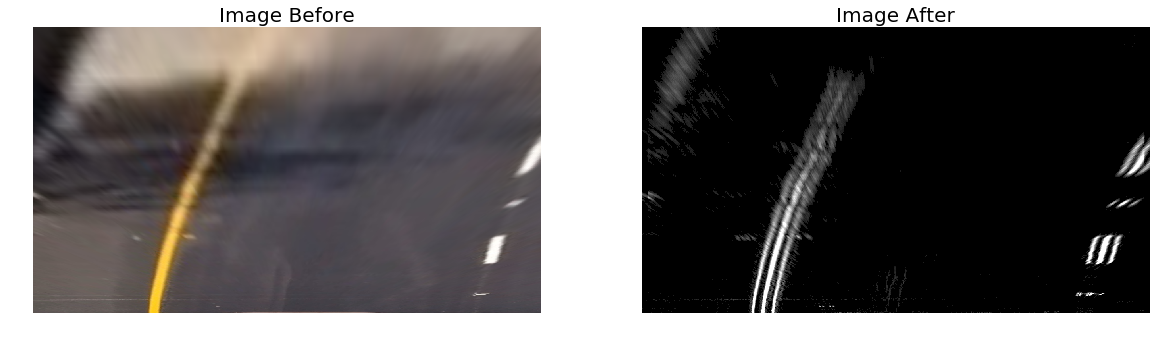

In [217]:
# Run the function
grad_binary = abs_sobel(warped, thresh_min=5)
compare_images(warped, grad_binary)

In [218]:
def combine_images(img1, img2, method="Add"):
    
    possible_methods = ['Add', 'Subtract']
    
    assert method.lower() in [x.lower() for x in possible_methods], \
        'The supplied combination method is not recognised.'
    
    img1 = np.array(img1, dtype=np.float32)
    img2 = np.array(img2, dtype=np.float32)
    
    if method.lower() == 'add':
        #return np.where(img2 + img1 > 255, 255, img1 + img2)
        return img1 + img2
    elif method.lower() == 'subtract':
        img2 = np.where(img2 > img1, img1, img2)
        return img1 - img2 #_t - img1
    else:
        print('Error: the supplied method is not recognised.')


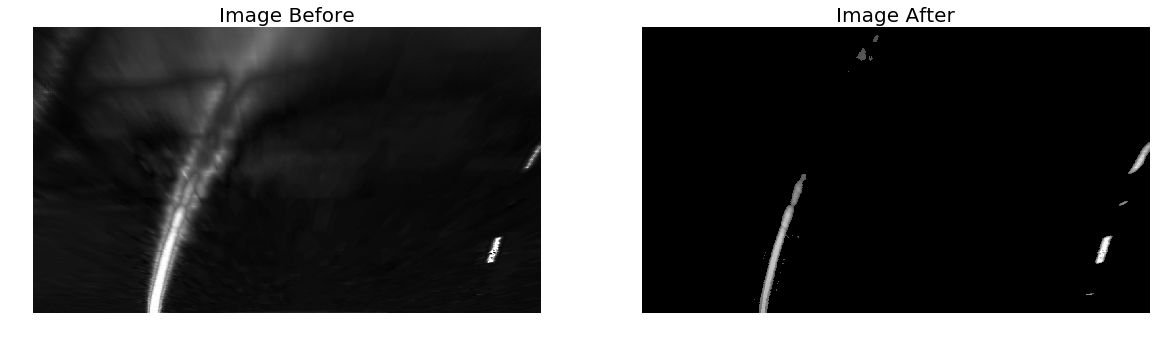

In [219]:
# Calculate saturation threshold
hls_img = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)
saturation_channel = hls_img[:,:,2]
lightness_channel = hls_img[:,:,1]
darkness_channel = (255-lightness_channel)
sobel_grad_red = abs_sobel(warped, thresh_min=5)

sum_img = combine_images(sobel_grad_red, saturation_channel, method='add') 
sum_img = combine_images(sum_img, lightness_channel, method='add') 
sum_img = combine_images(sum_img, darkness_channel, method='subtract') 

norm_img = np.zeros(sum_img.shape)
norm_img = cv2.normalize(sum_img, norm_img, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

norm_img = norm_img.astype(np.dtype('uint8'))
_, norm_thresh = cv2.threshold(norm_img, 80, 255, cv2.THRESH_TOZERO)

compare_images(saturation_channel, norm_thresh)

## Detect Lane Lines

Since the perspective transform leads to dramatic stretching of the pixels that were far away, the resolution of the lane lines decreases vertically.  It also means that thin slices of pixels near the bottom contain far more information than thicker bands of pixels near the top.  To compensate for this, the image is subdivided into exponentially decreasing bins towards the bottom.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


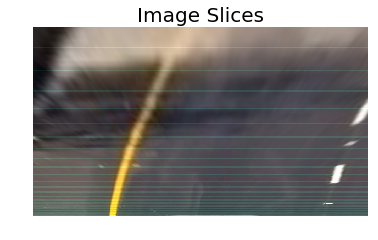

In [220]:
vertical_bins = np.arange(4.5, -0.1, -0.2)
image_height = 720 #px
vertical_bins = [int(4.5 * 2**b) for b in vertical_bins]
delta = image_height - sum(vertical_bins)
vertical_bins[0] += delta

position = 0
img_bins = np.copy(warped)

for vertical_bin in vertical_bins:
    position += vertical_bin
    line_overlay = np.zeros(img_bins.shape)
    line_overlay = cv2.line(line_overlay,(0,position),(1280,position),(0,255,180),3)
    img_bins = img_bins + (line_overlay * 0.1).astype(int)
plot_image(img_bins, title='Image Slices')

Now we need to detect the intensity peaks in the input images. This is done for both sides. It is assumed that the lane markings can cross over the center of the image.

The peaks are detected by getting the maximum value from the histogram and comparing it to the average over the histogram. Based on this a confidence score is retuned along with the detected peak position.

If a polynomial approximation of the left and/or right lane markins is supplied from a previous frame, the search is limited to a localised width near the polynomial, since it is not expected that the lane line position will change dramatically from one frame to the next. This technique is also powerful because it would track lane lines even when they pass through the center of the image.

In [221]:
def detect_peak(img_hist, peak_pos_y, img_average, offset=0):
    peak_pos = np.argmax(img_hist)
    peak_val = max(img_hist)
    hist_avg = img_average
    
    confidence = 'high'
    
    if peak_val < 20 * hist_avg:
        confidence = 'none'
    elif peak_val < 70.0 * hist_avg:
        confidence = 'low'
    elif peak_val < 200.0 * hist_avg:
        confidence = 'medium'
    
        
    peak_pos_x = peak_pos + offset
    
    return [peak_pos_x, peak_pos_y, confidence]

def detect_lines(img, v_bins, poly_left=None, poly_right=None):
    assert len(img.shape) == 2, 'Input image must be grayscale!'
    
    left_max =  int(img.shape[1] * 1/2)
    right_min = int(img.shape[1] * 1/2)
    
    img_mean = img.mean(axis=(0,1))
    search_margin = 150
    
    pos = 0
    left_peaks = []
    right_peaks = []
    
    for v_bin in v_bins:
        img_slice = img[pos:(pos + v_bin),:]
        histogram = np.sum(img_slice, axis=0)
        v_center = pos + int(v_bin/2)
        
        if poly_left is None:
            left_img_slice = img[pos:(pos + v_bin),:left_max]
            left_offset = 0
        else:
            l_center = poly_left[0] * v_center ** 2 + poly_left[1] * v_center ** 1 + poly_left[2]
            l_start = min(max(l_center - int(search_margin),0), img.shape[1])
            l_end = min(max(l_center + int(search_margin),0), img.shape[1])
            left_img_slice = img[pos:(pos + v_bin),l_start:l_end]
            left_offset = l_start
        
        if poly_right is None:
            right_img_slice = img[pos:(pos + v_bin),right_min:]
            right_offset = right_min
        else:
            r_center = poly_right[0] * v_center ** 2 + poly_right[1] * v_center ** 1 + poly_right[2]
            r_start = min(max(r_center - int(search_margin),0), img.shape[1])
            r_end = min(max(r_center + int(search_margin),0), img.shape[1])
            right_img_slice = img[pos:(pos + v_bin),r_start:r_end]
            right_offset = r_start
        
        left_hist = np.sum(left_img_slice, axis=0)
        right_hist = np.sum(right_img_slice, axis=0)
        left_peaks.append(detect_peak(left_hist, v_center, img_mean, offset=left_offset))
        right_peaks.append(detect_peak(right_hist, v_center, img_mean, offset=right_offset))
        pos += v_bin
    
    return left_peaks, right_peaks


To ensure that the projections are accurate, plot the result on an image below. The dots are colored by confidence level:

| Color | Confidence Level |
|:-----:|:----------------:|
| Green | High |
| Yellow | Medium |
| Orange | Low |
| Red | No Confidence |

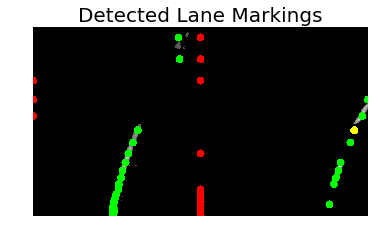

In [222]:
left_peaks, right_peaks = detect_lines(norm_thresh, vertical_bins)

norm_img_color = np.stack((norm_thresh, norm_thresh, norm_thresh), axis=-1)
img_peaks = np.copy(norm_img_color)

def mark_peak(img, peak_info):
    confidence = peak_info[2]
    if confidence == 'high':
        color = (0,255,0)
    elif confidence == 'medium':
        color = (255,255,0)
    elif confidence == 'low':
        color = (255,180,0)
    elif confidence == 'none':
        color = (255,0,0)
        
    return cv2.circle(img, (peak_info[0],peak_info[1]) , 15, color, -1)

for left_peak, right_peak in zip(left_peaks, right_peaks):
    img_peaks = mark_peak(img_peaks, left_peak)
    img_peaks = mark_peak(img_peaks, right_peak)
    
plot_image(img_peaks.astype(int),title='Detected Lane Markings')

## Get Curvature and Car Position

Get a polynomial that passes through all of the points that have a high or medium confidence:

In [223]:
def get_lane_poly(lane_points):
    accepted_confidence = ['high', 'medium']
    
    x_points, y_points, = zip(*[(float(point[0]), float(point[1])) 
                               for point in lane_points 
                               if point[2] in accepted_confidence])
    
    if len(x_points) < 3:
        x_points = [500] * 10
        y_points = range(0, 500, 50)
    
    poly_fit = np.polyfit(y_points, x_points, 2)
    
    return poly_fit

Plot the polynomials that were detected. The overlay image is larger than the original image so that when the lane curvature is high, the full polynomial can be displayed.

In [224]:
def get_highlighted_lane(l_poly, r_poly, img, padding=400):
    y = np.linspace(0, img.shape[0]-1, img.shape[0])
    
    x_l = l_poly[0] * y ** 2 + l_poly[1] * y + l_poly[2]
    x_r = r_poly[0] * y ** 2 + r_poly[1] * y + r_poly[2]
    
    lane_color = 'lightgreen'
    
    img_overlay_lines = np.zeros((img.shape[0], img.shape[1], 3))
    img_overlay_fill = np.zeros((img.shape[0], img.shape[1], 3))
    color = (0,255, 50)
    
    # Create a polygon that includes both curves
    pts_list = [[int(x), int(y[i])]
                  for i, x in enumerate(x_l)]
    pts_list.extend(reversed([[int(x), int(y[i])]
                  for i, x in enumerate(x_r)]))
    pts = np.array(pts_list, np.int32)
    
    img_overlay_lines = cv2.polylines(img_overlay_lines, [pts], True, color, 20)
    img_overlay_fill = cv2.fillPoly(img_overlay_fill, [pts], color)
    
    return img_overlay_lines, img_overlay_fill

In [225]:
def overlay_img(overlay, img, opacity=1.0):
    return (img + overlay * opacity)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


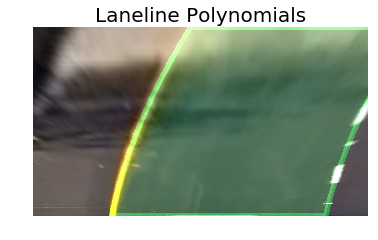

In [226]:
left_lane_poly = get_lane_poly(left_peaks)
right_lane_poly = get_lane_poly(right_peaks)

overlay_lines, overlay_fill = get_highlighted_lane(left_lane_poly, right_lane_poly, norm_img)

img_with_lanes = warped + overlay_lines * 0.3
img_with_lanes = img_with_lanes + overlay_fill * 0.15

plot_image(img_with_lanes.astype(int), title='Laneline Polynomials')

Convert the polynomial from pixel space to real world dimensions based on an expected lane width of 3.7 meters. The width of the lanes in pixel space is measured and fixed in this case because determining it dynamically was not seen as advantageous and likely to cause errors.

To ensure a higher accuracy, the lane with more data points is used for estimating the curvature.

Determine the offset of the car from the center of the road and the curvature of the road near the car.

## Original Perspective

In [ ]:
# transform overlay image into original perspective

## Visual Output

In [ ]:
# plot result on original image

# All together now

The full pipeline that takes an image or video frame as an input and gives the lane curvature, car position and annotated image as an output.